In [289]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import debug
from sklearn.cluster import KMeans


In [290]:
SIZE = 700

In [291]:
# Configure image
image = cv2.imread("../images/boards/yellow_black_up.jpeg")
image_size = (SIZE,SIZE)
image = cv2.resize(image,image_size)


In [292]:
def _detect_edges(image: np.ndarray) -> np.ndarray:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if gray.dtype != np.uint8:
        gray = gray / gray.max() * 255
        gray = gray.astype(np.uint8)
    edges = cv2.Canny(gray, 90, 400, 3)
    return edges

canny = _detect_edges(image)

Detect chessboard borders

In [293]:

def _generate_edges_lines(canny: np.ndarray) -> np.ndarray:
    
    lines = cv2.HoughLines(canny,rho = 1, theta = np.pi / 180, threshold = 100)
    
    lines = lines.reshape(len(lines),2)
        
    origin_lines = lines[lines[:, 1].argsort()]
    
    coor_lines = []
    for line in origin_lines:
        rho,theta = line
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 +1000*(-b))
        y1 = int(y0 +1000*(a))
        x2 = int(x0 -1000*(-b))
        y2 = int(y0 -1000*(a))   
        coor_lines.append(((x1,y1),(x2,y2)))
    
    return np.array(coor_lines)
    
lines = _generate_edges_lines(canny)

print(lines)

[[[  670  1000]
  [  670 -1000]]

 [[  524  1000]
  [  524 -1000]]

 [[  587  1000]
  [  587 -1000]]

 [[  597  1000]
  [  597 -1000]]

 [[  439  1000]
  [  439 -1000]]

 [[  290  1000]
  [  290 -1000]]

 [[  650  1000]
  [  650 -1000]]

 [[  365  1000]
  [  365 -1000]]

 [[  441  1000]
  [  441 -1000]]

 [[  449  1000]
  [  449 -1000]]

 [[  648  1000]
  [  648 -1000]]

 [[  667  1000]
  [  667 -1000]]

 [[  514  1000]
  [  514 -1000]]

 [[   60  1000]
  [   60 -1000]]

 [[  374  1000]
  [  374 -1000]]

 [[  297  1000]
  [  297 -1000]]

 [[  213  1000]
  [  213 -1000]]

 [[  437  1007]
  [  472  -991]]

 [[  284  1005]
  [  319  -994]]

 [[  361  1006]
  [  396  -993]]

 [[  427  1007]
  [  462  -992]]

 [[  429  1007]
  [  464  -992]]

 [[  277  1004]
  [  312  -994]]

 [[  638  1011]
  [  673  -988]]

 [[  502  1008]
  [  537  -990]]

 [[  575  1010]
  [  610  -989]]

 [[  500  1008]
  [  535  -990]]

 [[   45  1000]
  [   80  -998]]

 [[  209  1003]
  [  244  -995]]

 [[  123  1002

In [294]:
def _get_lines_averages(points):
    
    X = points
    n_clusters = 9
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X)
    labels = kmeans.labels_
    
    unique_labels = np.unique(labels)
    
    cluster_means = []
    
    for label in unique_labels: 
        cluster_data = X[labels == label]  # Extract data points with the current label
        cluster_mean = np.round(sum(cluster_data)/len(cluster_data))  # Compute the mean of the cluster group
        cluster_means.append(cluster_mean)
    
    
    
    #plt.scatter(cluster_means[:, 0], cluster_means[:, 1], cmap='viridis')
    #plt.xlabel('X-coordinate')
    #plt.ylabel('Y-coordinate')
    #plt.title('K-Means Clustering')
    #plt.show()
    
    return cluster_means


In [295]:
def _get_vertical_averages(lines):
    
    v_mask = np.array([any(value < -700 for _, value in row) for row in lines])
    
    #u_mask = np.array([any(value > 700 for _, value in row) for row in lines])
    
    vertical_lines = lines[v_mask]
    
    upper_points = np.column_stack(( vertical_lines[:,1,0],vertical_lines[:,1,1]))
    upper_points = upper_points[upper_points[:,1] < 900]
    bottom_points = np.column_stack((vertical_lines[:,0,0],vertical_lines[:,0,1]))  
    bottom_points = bottom_points[bottom_points[:,1] > 900] 
    
    bottom_averages = np.array(_get_lines_averages(bottom_points))
    upper_averages = np.array(_get_lines_averages(upper_points))
    
    
    index_b =np.argsort(bottom_averages[:, 0])
    bottom_averages = bottom_averages[index_b]
    #print( bottom_averages)
    index_u =np.argsort(upper_averages[:, 0])
    upper_averages = upper_averages[index_u]
    #print(upper_averages)
    result = np.concatenate((bottom_averages[:, np.newaxis, :], upper_averages[:, np.newaxis, :]), axis=1)
    
    return result

def _get_horizontal_averages(lines):

    h_mask = np.array([any(value < -700 for value,_ in row) for row in lines])

    horizontal_lines = lines[h_mask]

    upper_points = np.column_stack((horizontal_lines[:,1,0],horizontal_lines[:,1,1]))
    #upper_points = upper_points[upper_points[:,0] < 900]
    bottom_points = np.column_stack(( horizontal_lines[:,0,0],horizontal_lines[:,0,1]))
    #bottom_points = bottom_points[bottom_points[:,0] > 900] 
    bottom_averages = np.array(_get_lines_averages(bottom_points))
    upper_averages = np.array(_get_lines_averages(upper_points))
    
    
    index_b =np.argsort(bottom_averages[:, 1])
    bottom_averages = bottom_averages[index_b]
    #print( bottom_averages)
    index_u =np.argsort(upper_averages[:, 1])
    upper_averages = upper_averages[index_u]
    #print(upper_averages)
    result = np.concatenate((bottom_averages[:, np.newaxis, :], upper_averages[:, np.newaxis, :]), axis=1)
    
    return result

    #_cluster_points(bottom_points)
    #_cluster_points(upper_points)
    
points = _get_vertical_averages(lines).astype(int)
h_points = _get_horizontal_averages(lines).astype(int)
#print(points)

debug.lines(image,points, size = 3)
debug.lines(image,h_points, size = 3)


c:\Users\estudiante\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\estudiante\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\estudiante\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\estudiante\AppData\Local\Programs\Python\Python311\Lib\site-p

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

Detect chesboard corners

In [296]:
def line_intersection(lines):

    points =[]
    for i in range(len(lines)):
        for j in range(i + 1, len(lines)):

            line1 = lines[i]
            line2 = lines[j]
            xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
            ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

            def det(a, b):
                return a[0] * b[1] - a[1] * b[0]

            div = det(xdiff, ydiff)
            if div != 0:
                

                d = (det(*line1), det(*line2))
                x = det(d, xdiff) / div
                y = det(d, ydiff) / div
                points.append((x,y)) 
    return points

intersections = line_intersection( np.row_stack(( points,h_points)))

print(intersections)

debug.points(image,intersections,color = (0,255,0),size = 10)
#inters = np.array(intersections)
#inters = inters[np.all((-100 <= inters) & (inters <= 800), axis=1)] # Delete point outside -100 and 800
#sorted_intersections = inters[inters[:, 0].argsort()]

#print(len(sorted_intersections))

[(-94.61658101778161, 14090.545454545454), (-3417.552276138069, 302897.0), (941.5651992662998, -75967.16666666667), (1232.931132232783, -101290.66666666667), (1514.5640342847632, -125768.2393276192), (5277.604052026013, -452825.5), (-2359.5154577288645, 210939.8), (1307.821915318917, 87319.70488824278), (67.02750246554494, 41.566198755463), (66.21211634235868, 112.43388833152105), (65.37610684976453, 185.09401770959624), (64.48596608587586, 262.4588606232244), (63.57625511208573, 341.5246100408967), (62.72373553628717, 415.6196809983454), (61.7943896281464, 496.39196231892834), (60.9568607606583, -504.6258657424747), (60.12098229774804, -434.0971102479668), (396.6, -14790.1), (446.0, -17694.529411764706), (598.0170085042521, -26632.235294117647), (745.7251374312843, -35316.60440368051), (1127.1593489052218, -57742.692307692305), (2695.4762381190594, -149950.5), (942.2510224484232, -46871.170408070524), (144.3052814044368, 43.345366839141185), (143.10269783227338, 114.05020686133908), (

C:\Users\estudiante\AppData\Local\Temp\ipykernel_11624\3964718923.py:13: RuntimeWarning: overflow encountered in scalar multiply
  return a[0] * b[1] - a[1] * b[0]
C:\Users\estudiante\AppData\Local\Temp\ipykernel_11624\3964718923.py:13: RuntimeWarning: overflow encountered in scalar subtract
  return a[0] * b[1] - a[1] * b[0]


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

Trim image

In [297]:
vertex = np.array(sorted_intersections, np.int32)
black_mask = np.zeros_like(image)
cv2.fillPoly(black_mask, [vertex], (255, 255, 255))
trimmed_image = cv2.bitwise_and(image, black_mask)

Detect inner corners

In [298]:
gray_trimmed_image = cv2.cvtColor(trimmed_image, cv2.COLOR_BGR2GRAY)
max_corners = 80
corners = cv2.goodFeaturesToTrack(gray_trimmed_image, max_corners, qualityLevel= 0.1, minDistance= 15)
corners = np.intp(corners)
actual_size = corners.shape[0], corners.shape[2]
corners = corners.reshape(actual_size)

debug.points(trimmed_image,corners, color=(0,255,0), size= 5);

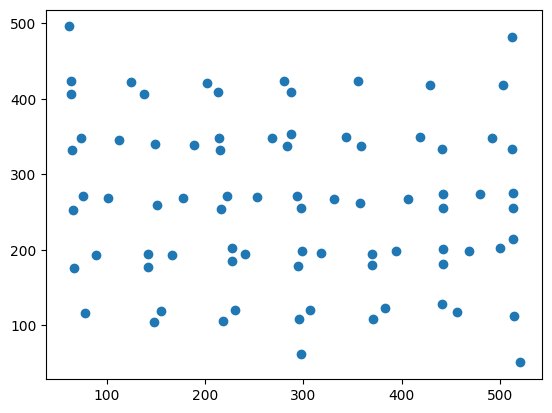

In [299]:
plt.scatter(corners[:,0], corners[:,1])

In [300]:
cv2.imshow('Imagen Original', image)
cv2.imshow('canny', canny)
#cv2.imshow('Imagen Recortada', trimmed_image)
cv2.waitKey(0)
cv2.destroyAllWindows()